In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_4.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_2.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_7.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_5.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_10.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_1.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_8.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_3.JPG
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_6.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_9.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/sweetcorn/Image_4.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/sweetcorn/I

# Fruit and Vegetable Classification

## Table of contents

1. Loading and preprocessing
2. Load the Images with a generator and Data Augmentation
3. Train the model
4. Visualize the result
5. Class activation heatmap for image classification
6. Deploy the model

## Context
This dataset contains images of the following food items:

**fruits:** banana, apple, pear, grapes, orange, kiwi, watermelon, pomegranate, pineapple, mango

**vegetables:** cucumber, carrot, capsicum, onion, potato, lemon, tomato, raddish, beetroot, cabbage, lettuce, spinach, soy bean, cauliflower, bell pepper, chilli pepper, turnip, corn, sweetcorn, sweet potato, paprika, jalepeño, ginger, garlic, peas, eggplant

## 1. Loading and preprocessing

In [17]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf

# Create a list with the filepaths for training and testing
train_dir = Path('/kaggle/input/fruit-and-vegetable-image-recognition/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path('/kaggle/input/fruit-and-vegetable-image-recognition/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

val_dir = Path('/kaggle/input/fruit-and-vegetable-image-recognition/validation')
val_filepaths = list(test_dir.glob(r'**/*.jpg'))

def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)

In [18]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 2780

Number of different labels: 36

Labels: ['kiwi' 'bell pepper' 'orange' 'grapes' 'ginger' 'corn' 'pear' 'lemon'
 'soy beans' 'onion' 'beetroot' 'potato' 'capsicum' 'turnip' 'sweetcorn'
 'chilli pepper' 'garlic' 'jalepeno' 'pineapple' 'cucumber' 'peas'
 'carrot' 'watermelon' 'cauliflower' 'tomato' 'paprika' 'pomegranate'
 'sweetpotato' 'eggplant' 'mango' 'lettuce' 'raddish' 'spinach' 'cabbage'
 'banana' 'apple']


In [29]:
train_df.head()

Filepath        Label
0  /kaggle/input/fruit-and-vegetable-image-recogn...         kiwi
1  /kaggle/input/fruit-and-vegetable-image-recogn...  bell pepper
2  /kaggle/input/fruit-and-vegetable-image-recogn...       orange
3  /kaggle/input/fruit-and-vegetable-image-recogn...       grapes
4  /kaggle/input/fruit-and-vegetable-image-recogn...       ginger

In [34]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()
len(df_unique)


36

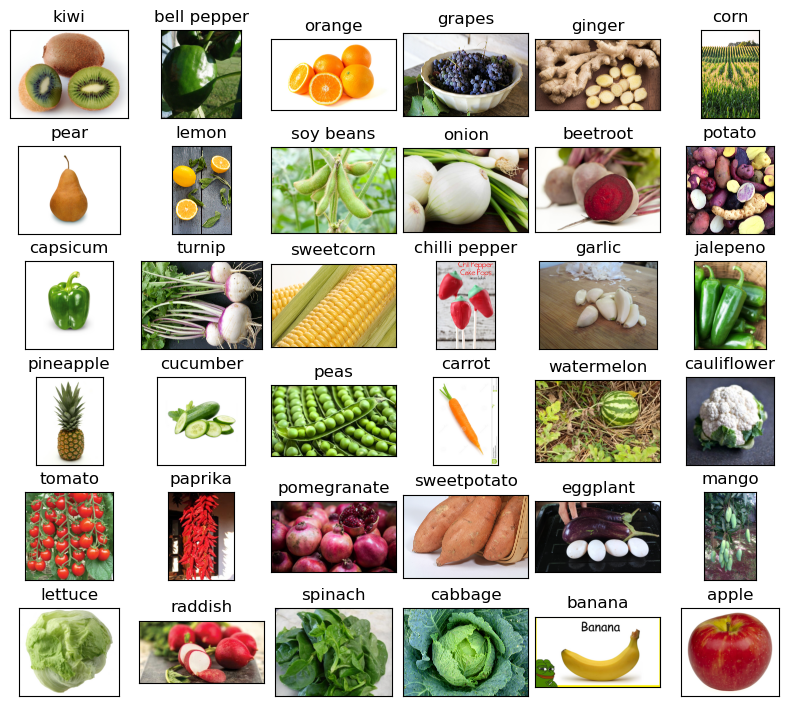

In [35]:
# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

## 2. Load the Images with a generator and Data Augmentation

In [41]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
    )

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2780 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.


In [42]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


## 3. Train the model

In [43]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5
87/87 [==============================] - 121s 1s/step - loss: 1.8349 - accuracy: 0.5245 - val_loss: 0.5172 - val_accuracy: 0.8293
Epoch 2/5
87/87 [==============================] - 72s 821ms/step - loss: 0.6112 - accuracy: 0.8025 - val_loss: 0.3324 - val_accuracy: 0.9012
Epoch 3/5
87/87 [==============================] - 73s 834ms/step - loss: 0.3856 - accuracy: 0.8748 - val_loss: 0.2373 - val_accuracy: 0.9102
Epoch 4/5
87/87 [==============================] - 72s 827ms/step - loss: 0.2449 - accuracy: 0.9252 - val_loss: 0.2065 - val_accuracy: 0.9491
Epoch 5/5
87/87 [==============================] - 79s 909ms/step - loss: 0.1616 - accuracy: 0.9529 - val_loss: 0.1874 - val_accuracy: 0.9491


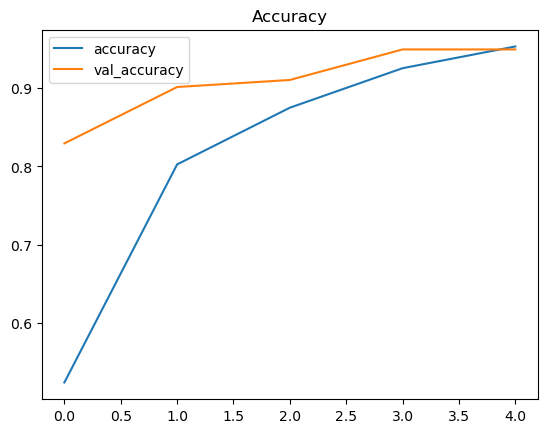

In [44]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title('Accuracy')
plt.show()

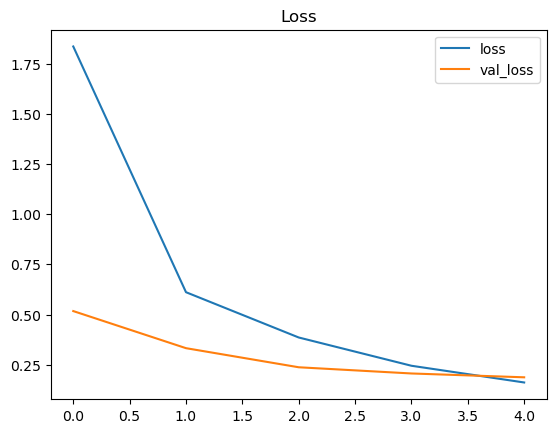

In [45]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title('Loss')
plt.show()

## 4. Visualize the result

In [46]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

11/11 [==============================] - 11s 939ms/step


In [47]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 94.91%


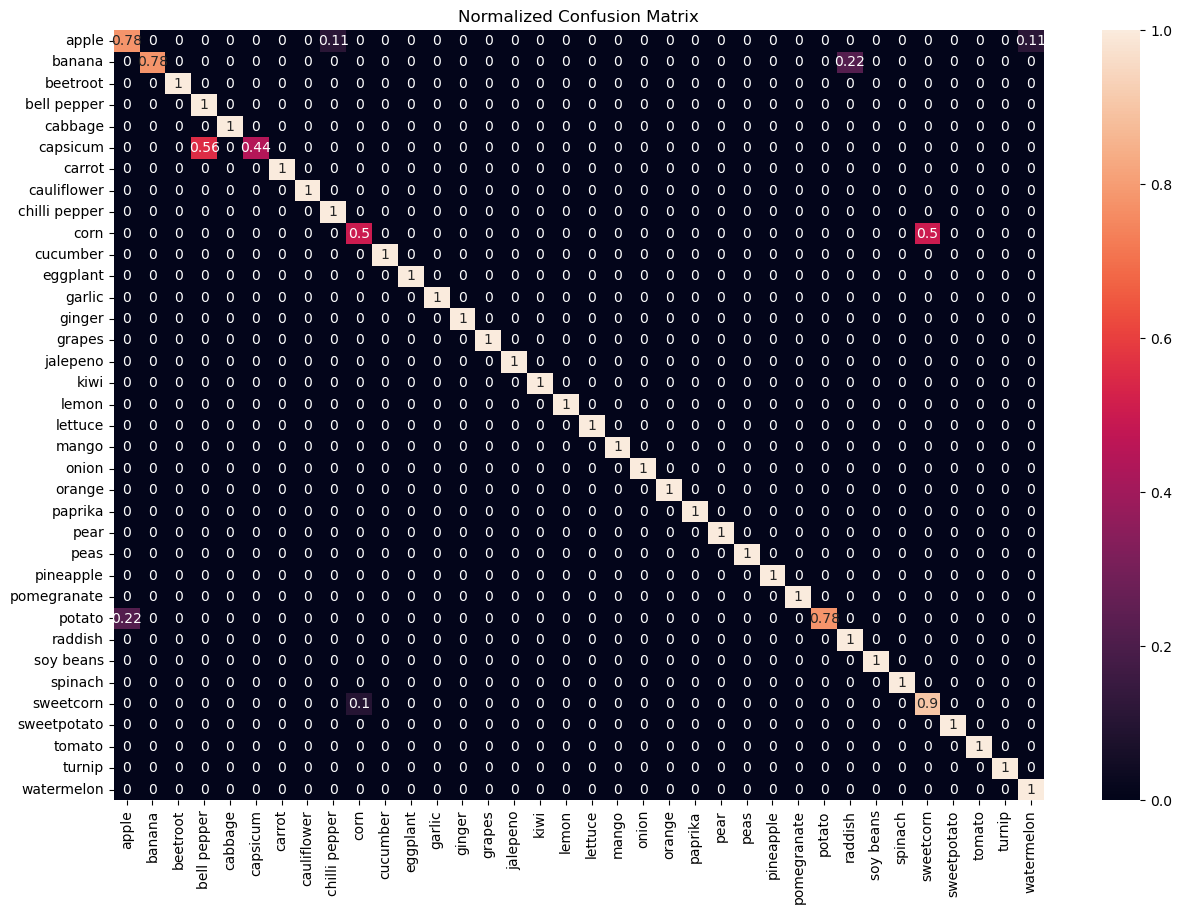

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Normalized Confusion Matrix')
plt.show()

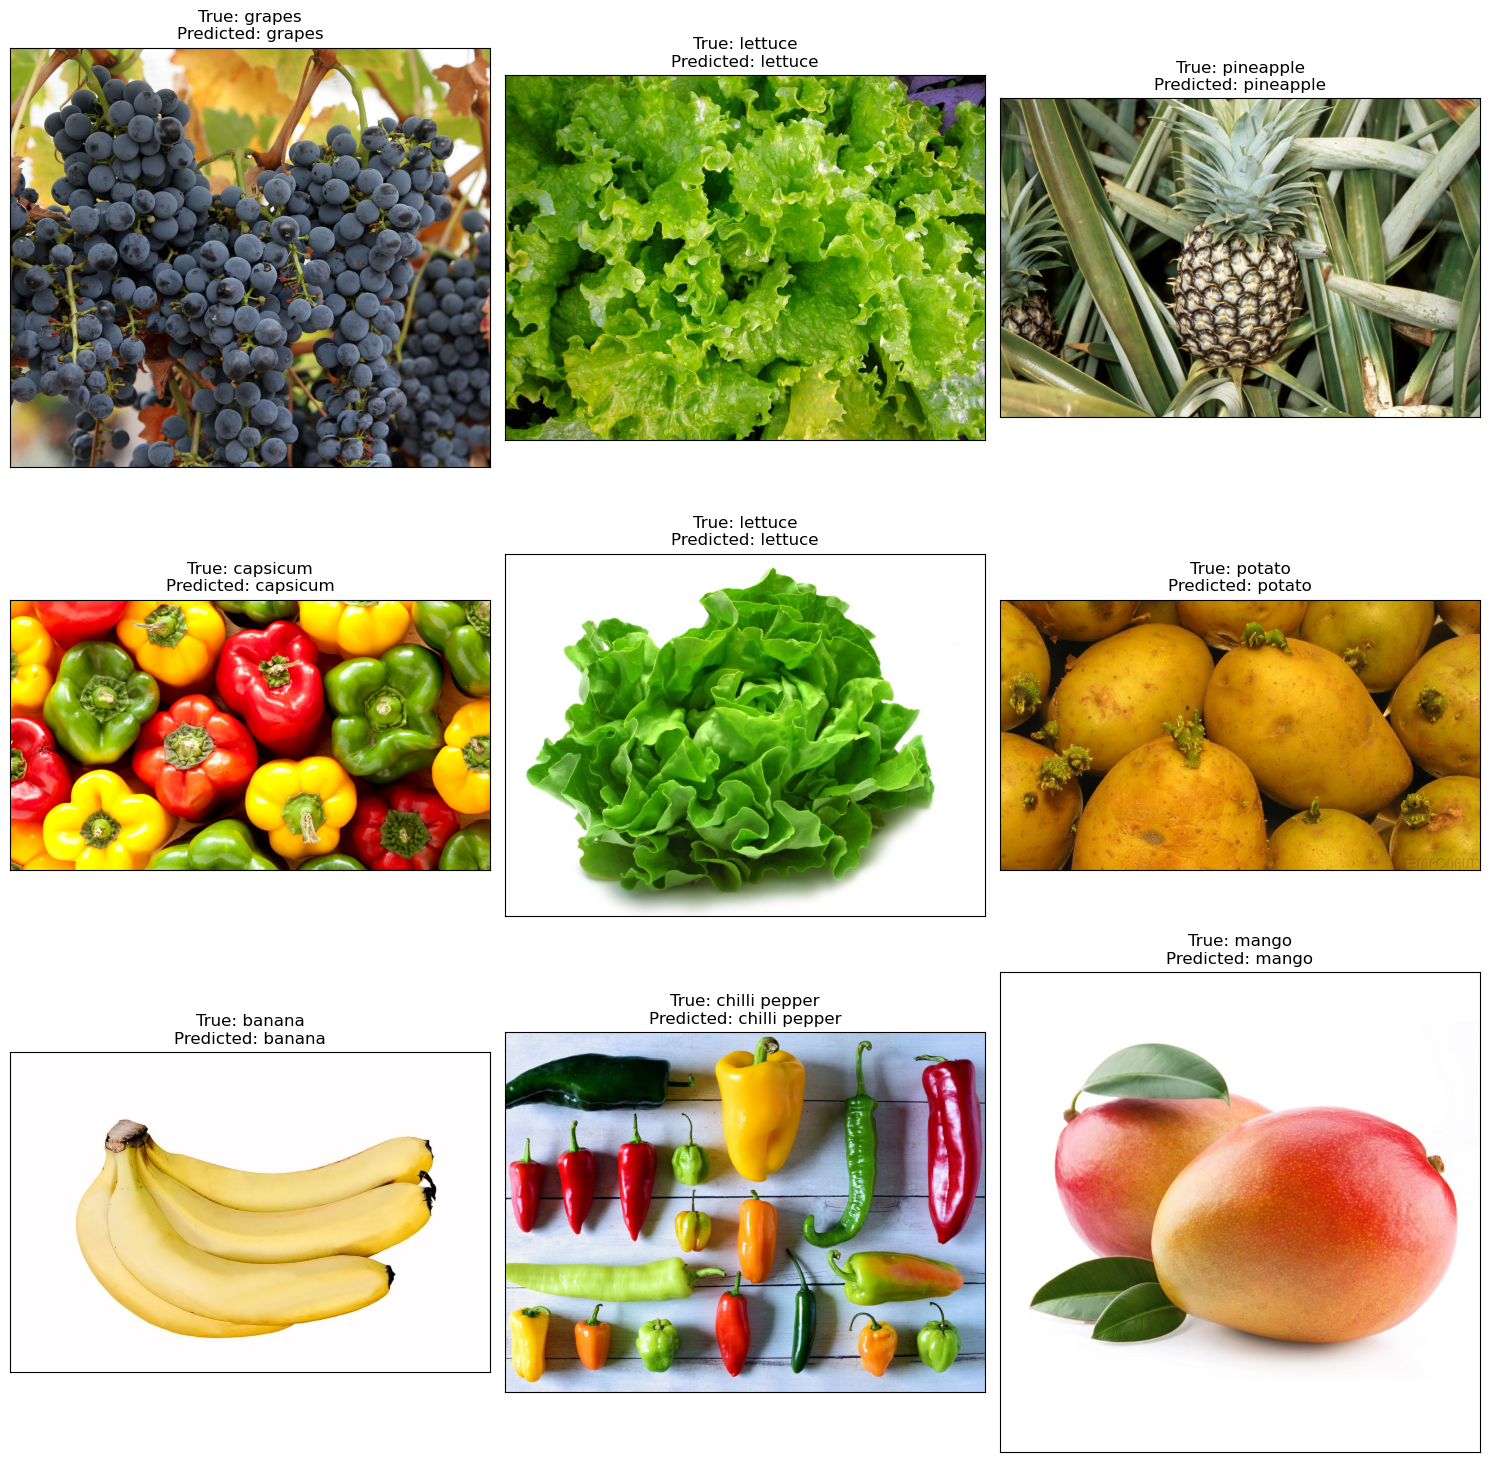

In [49]:
# Display some pictures of the dataset with their labels and the predictions
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

In [50]:
model.save('FruitModel.h5')